# Experiments analysis

In [1]:
import msgpack
import edge_sim_py
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mtick

## Experiments description

### Drawing topologies

In [2]:
datasets = [
    "datasets/central_minimal.json",
    "datasets/community_minimal.json",
    "datasets/p2p_minimal.json"
]

titles = [
    "Central Registry",
    "Community Registry",
    "P2P Registry"
]

def display_topology(topology: object):
    """Method that displays the topology of the network.
    Args:
        topology (object): The topology object.
    """
    positions = {}
    colors = []

    # Gathering the coordinates of edge servers
    edge_server_coordinates = [edge_server.coordinates for edge_server in edge_sim_py.EdgeServer.all()]

    # Gathering the coordinates of container registries
    container_registry_coordinates = [
        edge_server.coordinates
        for edge_server
        in edge_sim_py.EdgeServer.all()
        if len([registry for registry in edge_server.container_registries if registry.available]) > 0
    ]

    for node in topology.nodes():

        positions[node] = node.coordinates
        if node.coordinates in container_registry_coordinates:
            colors.append("#333333")
        elif node.coordinates in edge_server_coordinates:
            colors.append("#888888")
        else:
            colors.append("#dddddd")

    return positions, colors

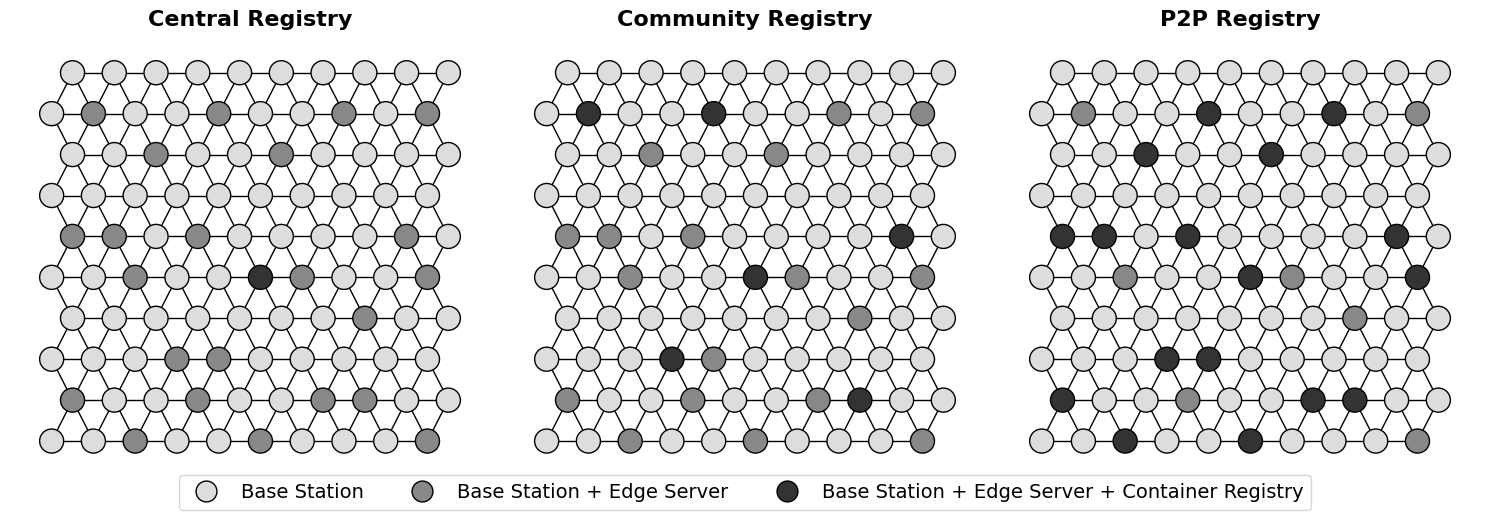

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, dataset in enumerate(datasets):
    # Creating a Simulator object
    simulator = edge_sim_py.Simulator()

    # Loading the dataset
    simulator.initialize(input_file=dataset)

    # Getting positions and colors
    positions, colors = display_topology(simulator.topology)
    
    # Drawing the topology
    nx.draw(
        simulator.topology,
        pos=positions,
        font_weight="bold",
        font_color="whitesmoke",
        node_color=colors,
        linewidths=1,
        edgecolors="black",
        ax=axs[i]
    )

    # Setting the title
    axs[i].set_title(titles[i], fontsize=16, fontweight="bold")


# Legend
bs_line = mlines.Line2D([], [], marker="o", markersize=15, label="Base Station", linewidth=0, markerfacecolor="#dddddd", markeredgecolor="black", markeredgewidth=1)
es_line = mlines.Line2D([], [], marker="o", markersize=15, label="Base Station + Edge Server", linewidth=0, markerfacecolor="#888888", markeredgecolor="black", markeredgewidth=1)
cr_line = mlines.Line2D([], [], marker="o", markersize=15, label="Base Station + Edge Server + Container Registry", linewidth=0, markerfacecolor="#333333", markeredgecolor="black", markeredgewidth=1)

fig.legend(
    handles=[bs_line, es_line, cr_line],
    loc="lower center",
    ncols=3,
    fontsize=14,
    bbox_to_anchor=(0.5, -0.05),
)

plt.tight_layout()
plt.savefig("logs/other/topologies.pdf", bbox_inches="tight")
plt.savefig("logs/other/topologies.svg", bbox_inches="tight")
plt.show()

## Base functions

#### Latency

In [4]:
def get_latency():
    user_data = []

    for seed in seeds:
        for log in logs:
            simulation_data = {
                "seed": seed,
                "dataset": log,
                "minimal": 0,
                "recommended": 0,
            }

            for requirement in requirements:
                # Opening file
                user_msgpack_file = f"{parent_dir}/algorithm={log[0]};dataset={log[1]}_{requirement};seed={seed}/User.msgpack"
                user_file = open(user_msgpack_file, "rb")
                user_msgpack = msgpack.load(user_file)
                user_df = pd.DataFrame(user_msgpack)

                # Collecting information
                latency = user_df[["Object", "Delays"]]

                # Persisting information
                simulation_data[requirement] = latency["Delays"].mean()

                # Closing file
                user_file.close()

            # Appending data
            user_data.append(simulation_data)

    return pd.DataFrame(user_data)

#### Service Reallocations

In [5]:
def get_reallocations_data(step):
    service_data = []

    for seed in seeds:
        for log in logs:
            simulation_data = {
                "seed": seed,
                "dataset": log,
                "minimal (total)": 0,
                "minimal (w/o cache)": 0,
                "recommended (total)": 0,
                "recommended (w/o cache)": 0,
            }

            for requirement in requirements:
                # Opening file
                service_msgpack_file = f"{parent_dir}/algorithm={log[0]};dataset={log[1]}_{requirement};seed={seed}/Service.msgpack"
                service_file = open(service_msgpack_file, "rb")
                service_msgpack = msgpack.load(service_file)
                service_df = pd.DataFrame(service_msgpack)

                # Collecting information
                migrations_last_step = service_df[service_df["Time Step"] == step][["Object", "Number of Finished Migrations", "Number of Finished Migrations Without Using Cache"]]

                # Persisting information
                simulation_data[f"{requirement} (total)"] = migrations_last_step["Number of Finished Migrations"].sum()
                simulation_data[f"{requirement} (w/o cache)"] = migrations_last_step["Number of Finished Migrations Without Using Cache"].sum()

                # Closing file
                service_file.close()

            # Appending data
            service_data.append(simulation_data)

    return pd.DataFrame(service_data)

#### Registry Usage

In [6]:
def get_registry_usage():
    registry_data = []

    for seed in seeds:
        for log in logs:
            simulation_data = {
                "seed": seed,
                "dataset": log,
                "minimal": 0,
                "recommended": 0,
            }

            for requirement in requirements:
                # Opening file
                registry_msgpack_file = f"{parent_dir}/algorithm={log[0]};dataset={log[1]}_{requirement};seed={seed}/ContainerRegistry.msgpack"
                registry_file = open(registry_msgpack_file, "rb")
                registry_msgpack = msgpack.load(registry_file)
                registry_df = pd.DataFrame(registry_msgpack)

                # Collecting information
                registry_filtered_data = (
                    registry_df[registry_df["P2P"] == True][["Object", "Provisioning", "Not Provisioning"]]
                    if log[1] == "p2p"
                    else registry_df[["Object", "Provisioning", "Not Provisioning"]]
                )
                registry_data_grouped = registry_filtered_data.groupby("Object").sum()
                registry_data_grouped["Total Steps"] = registry_data_grouped.sum(axis=1)
                registry_data_grouped["Provisioning Percentage"] = registry_data_grouped["Provisioning"] / registry_data_grouped["Total Steps"]
                registry_data_grouped["Not Provisioning Percentage"] = registry_data_grouped["Not Provisioning"] / registry_data_grouped["Total Steps"]

                # Persisting information
                simulation_data[requirement] = registry_data_grouped["Provisioning Percentage"].mean()

                # Closing file
                registry_file.close()

            # Appending data
            registry_data.append(simulation_data)

    return pd.DataFrame(registry_data)

#### Number of Registries over Time

In [7]:
def get_number_of_registries(seed, requirement):
    registry_data = {}

    for log in logs:
        # Opening file
        registry_msgpack_file = f"{parent_dir}/algorithm={log[0]};dataset={log[1]}_{requirement};seed={seed}/ContainerRegistry.msgpack"
        registry_file = open(registry_msgpack_file, "rb")
        registry_msgpack = msgpack.load(registry_file)
        registry_df = pd.DataFrame(registry_msgpack)

        # Collecting information
        registries_per_timestep = registry_df[registry_df["Time Step"] > 0].groupby(["Time Step"]).count()["Object"]

        # Persisting information
        registry_data[log[0].capitalize()] = registries_per_timestep

        # Closing file
        registry_file.close()

    registries_per_timestep_df = pd.concat(registry_data, axis=1)

    return registries_per_timestep_df

#### Plot Data

In [8]:
def calculate_x(x, width, i, n):
    return x + width * (i - n / 2) + width / 2


def plot_data_with_grouped_bar(
    keys: list,
    mean_df: pd.DataFrame,
    std_df: pd.DataFrame,
    xlabel: str,
    ylabel: str,
    filename: str,
    bbox_to_anchor: tuple,
    yscale: str = "linear",
    yticks: list = None,
):
    # Plotting bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    width = 0.8

    hatches = ["", "/", "|", "\\"]

    x = np.arange(len(mean_df))

    for key in keys:
        ax.bar(
            x=calculate_x(x, width/len(keys), keys.index(key), len(keys)),
            height=mean_df[key],
            width=width/len(keys),
            label=key.title(),
            yerr=std_df[key],
            hatch=hatches.pop(0),
            color="#aaaaaa",
            edgecolor="black",
            linewidth=2,
            error_kw={"elinewidth": 2, "capthick": 2, "capsize": 5}
        )

    # Setting labels and ticks
    ax.legend(fontsize=20, bbox_to_anchor=bbox_to_anchor, loc="upper center", ncol=2)
    ax.set_xlabel(xlabel, fontsize=24, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=24, fontweight="bold", labelpad=10, loc="center")
    ax.set_xticks(x, labels)
    ax.tick_params(axis="x", labelsize=24)
    ax.tick_params(axis="y", labelsize=24)
    ax.set_yscale(yscale)
    if yscale == "log":
        ax.set_yticks(yticks)
        ax.get_yaxis().set_major_formatter(mtick.ScalarFormatter())
    if xlabel == "% of Steps Active":
        ax.get_yaxis().set_major_formatter(mtick.PercentFormatter())

    # Saving figure
    plt.tight_layout()
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")
    plt.show()

In [9]:
def plot_registries_over_time(
    labels: list,
    data: pd.DataFrame,
    xlabel: str,
    ylabel: str,
    filename: str,
    bbox_to_anchor,
):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_xlabel(xlabel, fontsize=24, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=24, fontweight="bold", labelpad=10, loc="center")
    ax.tick_params(axis="x", labelsize=24)
    ax.tick_params(axis="y", labelsize=24)

    p = ax.plot(
        data,
        linewidth=2,
    )

    # Setting line styles and colors
    p[0].set_linestyle((0, (1, 10))) # loosely dotted
    p[0].set_color("black")
    p[1].set_linestyle((0, (5, 5))) # dashed
    p[1].set_color("black")
    p[2].set_color("black") 

    # Adding legend
    ax.legend(labels, fontsize=20, bbox_to_anchor=bbox_to_anchor, loc="upper center", ncol=3)

    # Saving figure
    plt.tight_layout()
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")
    plt.show()

## Results

### Base Comparison

In [10]:
parent_dir = "logs"

LAST_STEP = 3600

logs = [
    ("central", "central"),
    ("community", "community"),
    ("p2p", "p2p"),
]

seeds = [1, 2, 3, 4, 5]

requirements = ["minimal", "recommended"]

labels = ["Central", "Community", "P2P"]

#### User latency

In [11]:
# Getting latency data
latency_df = get_latency()

# Calculating mean values and standard deviations
latency_mean_df = latency_df.groupby(["dataset"]).mean()
latency_std_df = latency_df.groupby(["dataset"]).std()

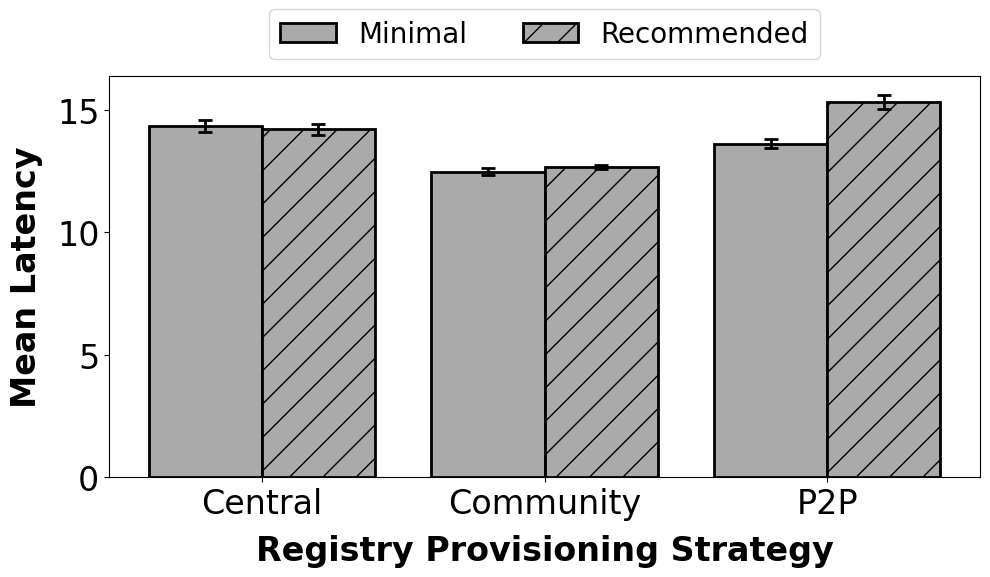

In [12]:
plot_data_with_grouped_bar(
    ["minimal", "recommended"],
    latency_mean_df,
    latency_std_df,
    "Registry Provisioning Strategy",
    "Mean Latency",
    "logs/other/app_mean_latency_grouped",
    (0.5, 1.2)
)

#### Service reallocations

In [13]:
# Getting reallocations data
reallocations_df = get_reallocations_data(LAST_STEP)

# Calculating mean values and standard deviations
reallocations_mean_df = reallocations_df.groupby(["dataset"]).mean()
reallocations_std_df = reallocations_df.groupby(["dataset"]).std()

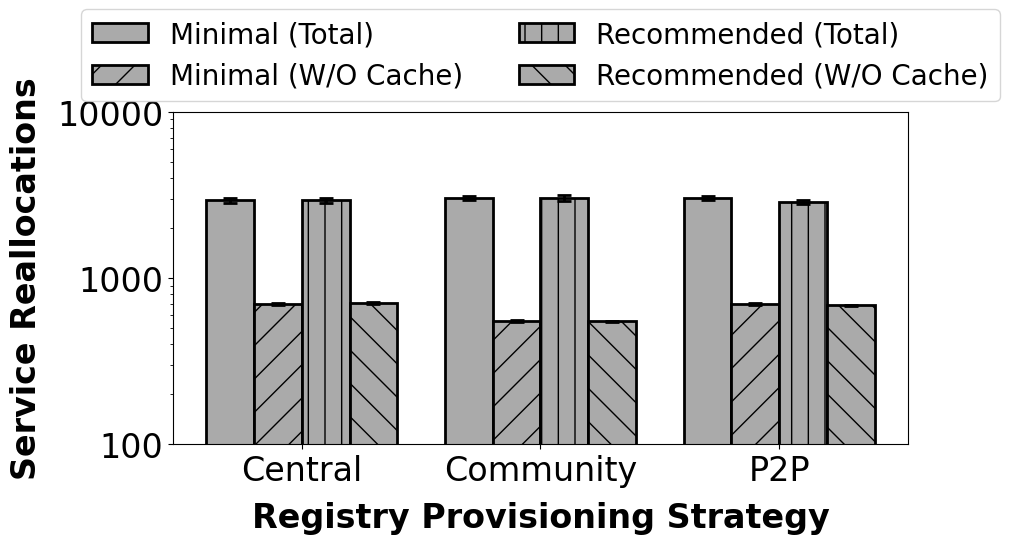

In [14]:
plot_data_with_grouped_bar(
    [
        "minimal (total)",
        "minimal (w/o cache)",
        "recommended (total)",
        "recommended (w/o cache)",
    ],
    reallocations_mean_df,
    reallocations_std_df,
    "Registry Provisioning Strategy",
    "Service Reallocations",
    "logs/other/service_reallocations_grouped",
    (0.5, 1.35),
    "log",
    [100, 1000, 10000]
)

#### Registry Usage

In [15]:
# Getting reallocations data
registry_usage_df = get_registry_usage()

# Calculating mean values and standard deviations
registry_usage_mean_df = registry_usage_df.groupby(["dataset"]).mean()
registry_usage_std_df = registry_usage_df.groupby(["dataset"]).std()

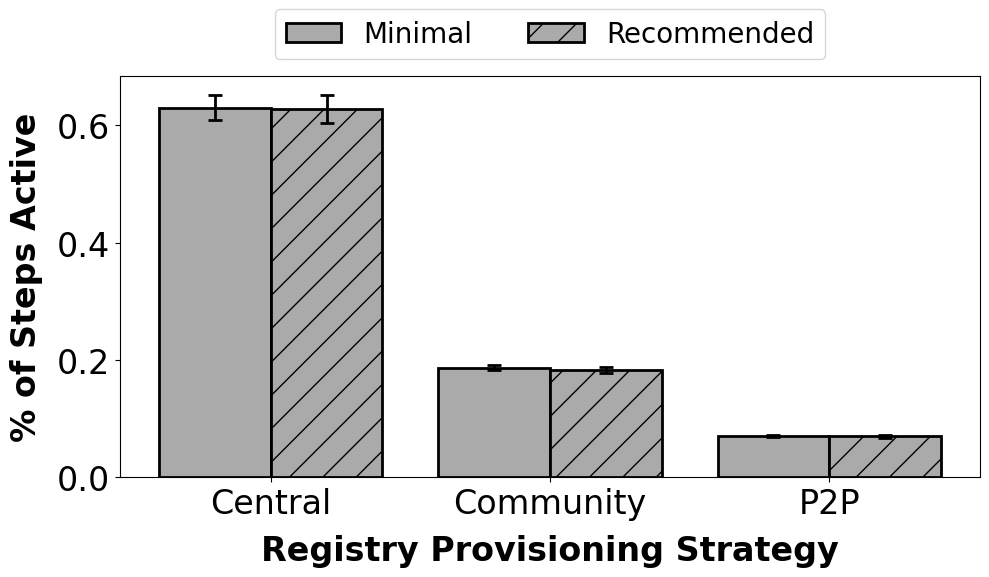

In [16]:
plot_data_with_grouped_bar(
    ["minimal", "recommended"],
    registry_usage_mean_df,
    registry_usage_std_df,
    "Registry Provisioning Strategy",
    "% of Steps Active",
    "logs/other/registry_usage_grouped",
    (0.5, 1.2),
    fmt=
)

#### Number of registries

In [17]:
seed = 1
requirement = "minimal"

registry_df = get_number_of_registries(seed, requirement)

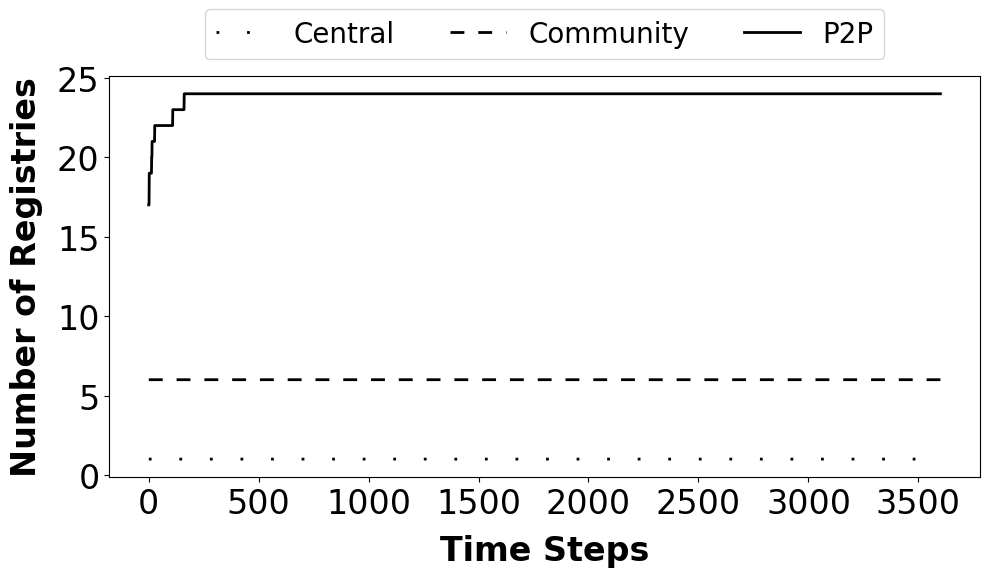

In [18]:
plot_registries_over_time(
    labels,
    registry_df,
    "Time Steps",
    "Number of Registries",
    "logs/other/number_of_registries_over_time",
    (0.5, 1.2)
)

### P2P-based variation comparison

In [19]:
logs = [
    ("community", "community"),
    ("p2p", "p2p"),
    ("p2p_enhanced", "p2p")
]

labels = ["Community", "P2P", "Dynamic"]

#### User latency

In [20]:
# Getting data transferred data
latency_df_2 = get_latency()

# Calculating mean values and standard deviations
latency_mean_df_2 = latency_df_2.groupby(["dataset"]).mean()
latency_std_df_2 = latency_df_2.groupby(["dataset"]).std()

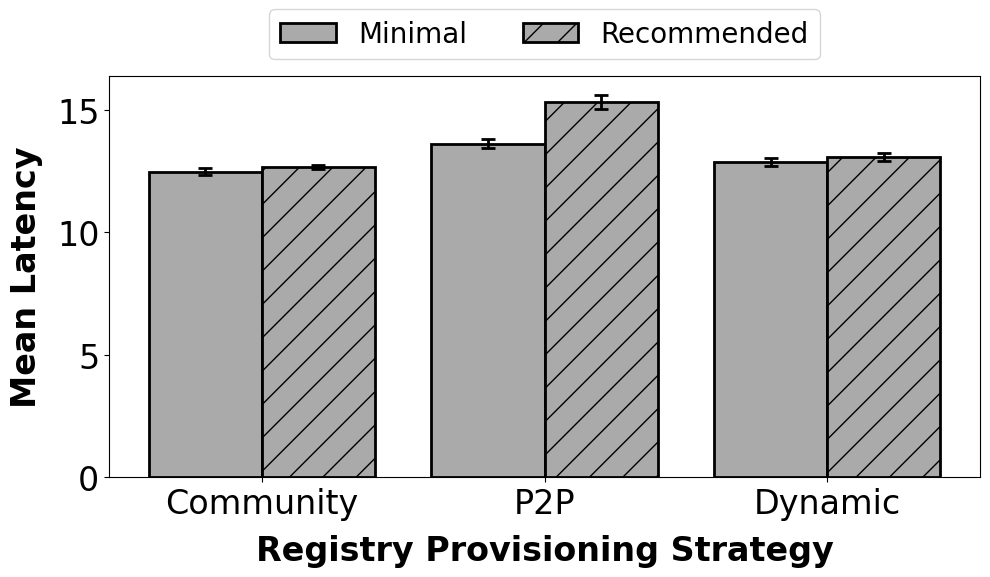

In [21]:
plot_data_with_grouped_bar(
    ["minimal", "recommended"],
    latency_mean_df_2,
    latency_std_df_2,
    "Registry Provisioning Strategy",
    "Mean Latency",
    "logs/other/app_mean_latency_grouped_2",
    (0.5, 1.2)
)

#### Service reallocations

In [22]:
# Getting reallocations data
reallocations_df_2 = get_reallocations_data(LAST_STEP)

# Calculating mean values and standard deviations
reallocations_mean_df_2 = reallocations_df_2.groupby(["dataset"]).mean()
reallocations_std_df_2 = reallocations_df_2.groupby(["dataset"]).std()

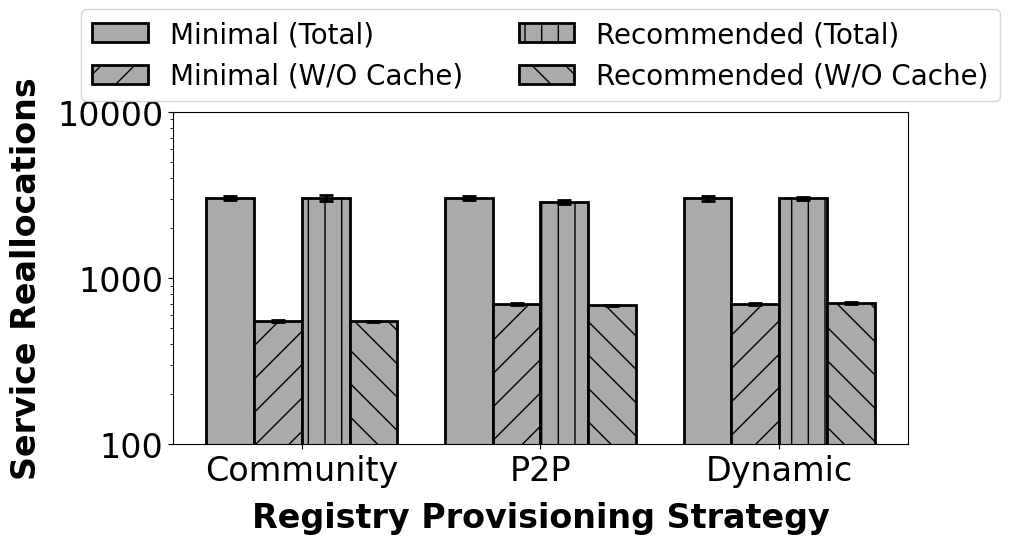

In [23]:
plot_data_with_grouped_bar(
    [
        "minimal (total)",
        "minimal (w/o cache)",
        "recommended (total)",
        "recommended (w/o cache)",
    ],
    reallocations_mean_df_2,
    reallocations_std_df_2,
    "Registry Provisioning Strategy",
    "Service Reallocations",
    "logs/other/service_reallocations_grouped_2",
    (0.5, 1.35),
    "log",
    [100, 1000, 10000]
)

#### Registry Usage

In [24]:
# Getting data transferred data
registry_usage_df_2 = get_registry_usage()

# Calculating mean values and standard deviations
registry_usage_mean_df_2 = registry_usage_df_2.groupby(["dataset"]).mean()
registry_usage_std_df_2 = registry_usage_df_2.groupby(["dataset"]).std()

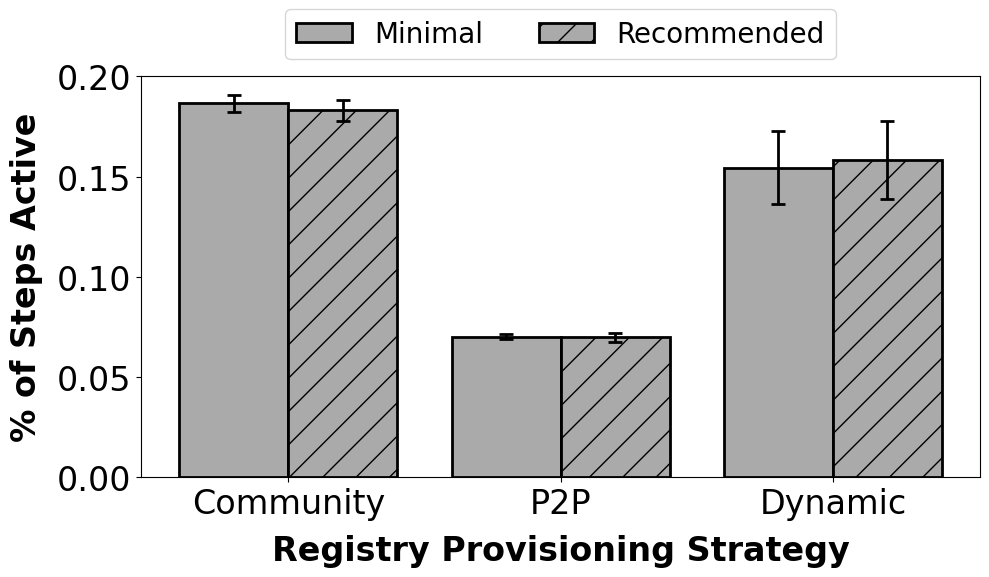

In [25]:
plot_data_with_grouped_bar(
    ["minimal", "recommended"],
    registry_usage_mean_df_2,
    registry_usage_std_df_2,
    "Registry Provisioning Strategy",
    "% of Steps Active",
    "logs/other/registry_usage_grouped_2",
    (0.5, 1.2)
)

#### Number of Registries

In [26]:
seed = 1
requirement = "minimal"

registry_df = get_number_of_registries(seed, requirement)

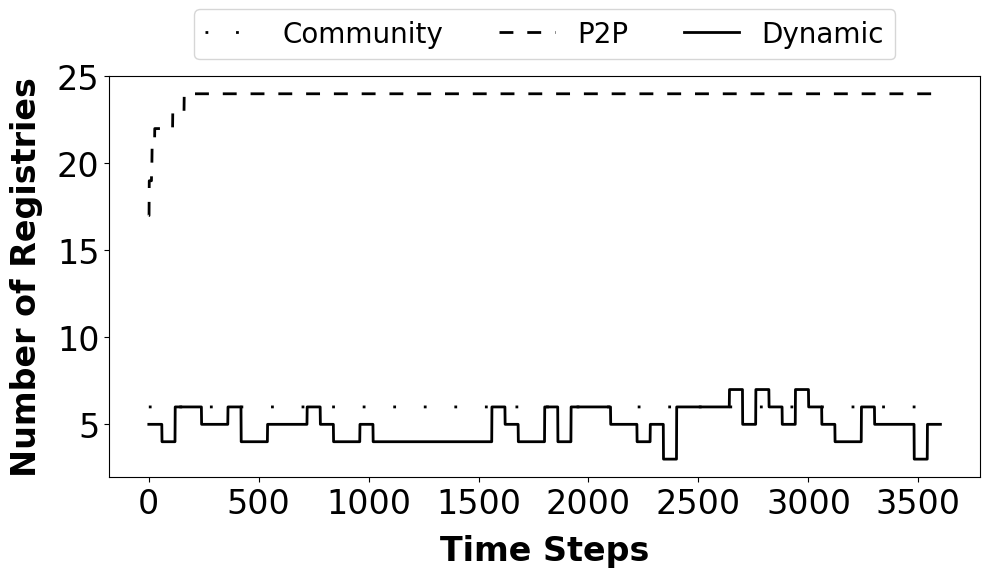

In [27]:
plot_registries_over_time(
    labels,
    registry_df,
    "Time Steps",
    "Number of Registries",
    "logs/other/number_of_registries_over_time_2",
    (0.5, 1.2)
)